In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

print("numpy version:", np.__version__)
print("tensorflow version:", tf.__version__)
print("pandas version:", pd.__version__)

numpy version: 1.13.3
tensorflow version: 1.4.0
pandas version: 0.19.2


See original notebook SkillCraft_Experiment1_Rank_with_GM for details.

In [2]:
skillcraft = pd.read_csv('SkillCraft1_Dataset.csv')
sc = skillcraft.query('LeagueIndex == 3 | LeagueIndex == 5')

In [3]:
data = sc.iloc[:, 5:]
data = data.values

target = sc.iloc[:, 1]
target = target.values

# reassign labels for two-class
posClass = 3
negClass = 5
dataIndx = (target==posClass) + (target==negClass)
data = data[dataIndx]
target = target[dataIndx]
target[target==posClass] = 1
target[target==negClass] = 0

#np.random.seed(45689)
rnd_idx = np.arange(np.shape(data)[0])
np.random.shuffle(rnd_idx)

# trBatch = int(np.ceil(0.8*len(rnd_idx)))
# validBatch = int(np.ceil(0.1*len(rnd_idx)))
#trBatch = int(np.ceil(0.7*len(rnd_idx)))
trBatch=1220

trainData, testData = (data[rnd_idx[0:trBatch],:],
                       data[rnd_idx[trBatch:],:])

trainTarget, testTarget = (target[rnd_idx[0:trBatch]],
                           target[rnd_idx[trBatch:]])

In [4]:
print("trainData shape:", trainData.shape)
print("trainTarget shape:", trainTarget.shape)
print("testData shape:", testData.shape)
print("testTarget shape:", testTarget.shape)

trainData shape: (1220, 15)
trainTarget shape: (1220,)
testData shape: (139, 15)
testTarget shape: (139,)


In [5]:
print(trainData.dtype)
print(trainTarget.dtype)
print(np.unique(trainTarget))
print(np.unique(testTarget))
print(np.bincount(trainTarget))
print(np.bincount(testTarget))

float64
int64
[0 1]
[0 1]
[730 490]
[76 63]


In [6]:
# need to expand the targets (currently just a scalar) into a one-hot 10-D vector
# code from https://stackoverflow.com/a/42874726/8346497
classes = np.unique(trainTarget).shape[0]
trainTarget = np.eye(classes)[trainTarget]
testTarget = np.eye(classes)[testTarget]

print("new trainTarget shape:", trainTarget.shape)
print("new testTarget shape:", testTarget.shape)

new trainTarget shape: (1220, 2)
new testTarget shape: (139, 2)


In [7]:
def build_layer(incoming, num_hidden_units):
    """
    incoming: the input tensor containing the hidden activations from previous layer
    num_hidden_units: the number of hidden units for this layer
    
    takes the hidden activations from the previous layer and then returns the weighted sum of
    the inputs for the current hidden layer (before passing through activation)
        
    also return the weights W_layer for regularization
    """
    # Xavier initialization
    num_input_units = incoming.get_shape().as_list()[1]
    variance = 3. / (num_input_units + num_hidden_units)
    
    W_layer = tf.Variable(tf.truncated_normal(shape=[num_input_units, num_hidden_units], stddev=tf.sqrt(variance)))
    b_layer = tf.Variable(tf.constant(0.0, shape=[num_hidden_units]))
    
    # the output of this hidden layer
    layer = tf.matmul(incoming, W_layer) + b_layer
    return layer, W_layer

In [8]:
def cross_validation(data, target, i, cv_index):
    """
    data:
    target:
    
    Returns two datasets (composed of data and labels) partitioned into size (i-1)*N/i and N/i.
    The split is made along cv_index (should be greater than 1)
    Precondition: i >= 3, 1 <= cv_index <= i-1
    """
    data_cv = np.split(data, i)
    target_cv = np.split(target, i)
    
    trainData = np.concatenate(data_cv[0:cv_index] + data_cv[cv_index+1:], axis=0)
    trainTarget = np.concatenate(target_cv[0:cv_index] + target_cv[cv_index+1:], axis=0)
    
    validData = data_cv[cv_index]
    validTarget = target_cv[cv_index]
    
    return trainData, trainTarget, validData, validTarget

## Experiment 1: Fully connected neural network


In [17]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer_in, W_layer1 = build_layer(X, 500)
keep_prob = tf.placeholder(tf.float32) # control dropout to activate during training only
hidden_layer_out = tf.nn.dropout(tf.nn.relu(hidden_layer_in), keep_prob)

# hidden layer to output
y_predicted, W_layer2 = build_layer(hidden_layer_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 3e-4
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2)
cross_entropy += penalty * regularizers

In [18]:
global_step = tf.Variable(0, trainable=False)
eta_0 = 1e-3
eta = tf.train.exponential_decay(eta_0, global_step, 5000, 0.9, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy, global_step=global_step)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))

In [20]:
batch_size=256

train_errors = []
valid_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    
    split = 10
    
    for partition in range(0, split):
        trainDataCV, trainTargetCV, validData, validTarget = cross_validation(trainData, trainTarget, split, partition)
        
        for step in range(1, 101):
            if i >= trainData.shape[0]:
                i -= trainData.shape[0]
                train_error, train_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                               y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                               keep_prob: 1.0})
                valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: validData, y_target: validTarget,
                                                               keep_prob: 1.0})
                train_xentropy_losses.append(train_loss)
                train_errors.append(train_error)
                valid_xentropy_losses.append(valid_loss)
                valid_errors.append(valid_error)

            indices = range(i, i+batch_size)
            _, loss = sess.run([train, cross_entropy], feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                                  y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                                  keep_prob: 0.5})
            i += batch_size

            if (step % 20 == 0):
                train_error, train_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                               y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                               keep_prob: 1.0})
                valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: validData, y_target: validTarget,
                                                               keep_prob: 1.0})
                print("Iter: %4d, xentropy-train: %4.6f, xentropy-valid: %4.6f, Train errs: %d, Valid errs: %d"%
                      (partition*100+step, train_loss, valid_loss, train_error, valid_error))

Iter:   20, xentropy-train: 1.825336, xentropy-valid: 2.571659, Train errs: 56, Valid errs: 24
Iter:   40, xentropy-train: 1.274556, xentropy-valid: 1.651791, Train errs: 61, Valid errs: 23
Iter:   60, xentropy-train: 0.988262, xentropy-valid: 1.573371, Train errs: 50, Valid errs: 28
Iter:   80, xentropy-train: 0.756338, xentropy-valid: 1.098517, Train errs: 62, Valid errs: 25
Iter:  100, xentropy-train: 0.776475, xentropy-valid: 0.844905, Train errs: 54, Valid errs: 24
Iter:  120, xentropy-train: 0.439882, xentropy-valid: 0.475269, Train errs: 46, Valid errs: 20
Iter:  140, xentropy-train: 0.604059, xentropy-valid: 0.463335, Train errs: 65, Valid errs: 19
Iter:  160, xentropy-train: 0.602489, xentropy-valid: 0.468913, Train errs: 65, Valid errs: 20
Iter:  180, xentropy-train: 0.460966, xentropy-valid: 0.465305, Train errs: 57, Valid errs: 18
Iter:  200, xentropy-train: 0.545708, xentropy-valid: 0.459409, Train errs: 59, Valid errs: 18
Iter:  220, xentropy-train: 0.459565, xentropy-val

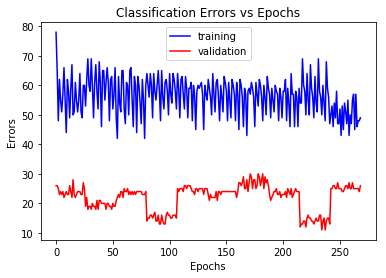

In [21]:
# plot training curve for classification error vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.title('Classification Errors vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

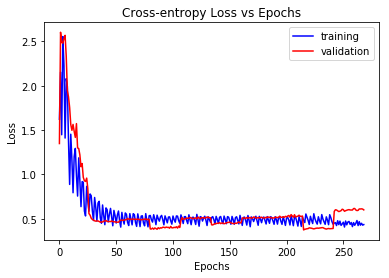

In [22]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.title('Cross-entropy Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

One layer, 1000 units, $\eta=0.001$, $\lambda=0.0003$, dropout rate $p=0.5$

### Result on test set

In [9]:
X = tf.placeholder(tf.float32, shape=[None, trainData.shape[1]])
y_target = tf.placeholder(tf.float32, shape=[None, trainTarget.shape[1]])

# input to hidden layer
hidden_layer_in, W_layer1 = build_layer(X, 500)
keep_prob = tf.placeholder(tf.float32) # control dropout to activate during training only
hidden_layer_out = tf.nn.dropout(tf.nn.relu(hidden_layer_in), keep_prob)
#hidden_layer_out = tf.nn.relu(hidden_layer_in)

# hidden layer to output
y_predicted, W_layer2 = build_layer(hidden_layer_out, trainTarget.shape[1])

# perform a softmax on the output layer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_target, logits=y_predicted))

# add L2 norm penalty for every weight in the network
penalty = 3e-4
regularizers = tf.nn.l2_loss(W_layer1) + tf.nn.l2_loss(W_layer2)
cross_entropy += penalty * regularizers

In [10]:
global_step = tf.Variable(0, trainable=False)
eta_0 = 1e-3
eta = tf.train.exponential_decay(eta_0, global_step, 5000, 0.9, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate=eta)
train = optimizer.minimize(cross_entropy, global_step=global_step)
y_class_predicted = tf.argmax(y_predicted, 1)
y_class_target = tf.argmax(y_target, 1)
errors = tf.reduce_sum(tf.cast(tf.not_equal(y_class_predicted, y_class_target), tf.float32))
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_class_predicted, y_class_target), tf.float32))

In [15]:
batch_size=256

train_accuracies = []
valid_accuracies = []
test_accuracies = []
train_errors = []
valid_errors = []
test_errors = []
train_xentropy_losses = []
valid_xentropy_losses = []
test_xentropy_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    i=0
    
    split = 10
    
    for partition in range(0, split):
        trainDataCV, trainTargetCV, validData, validTarget = cross_validation(trainData, trainTarget, split, partition)
        
        for step in range(1, 101):
            if i >= trainData.shape[0]:
                i -= trainData.shape[0]
                train_acc, train_error, train_loss = sess.run([accuracy, errors, cross_entropy],
                                                               feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                                          y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                                          keep_prob: 1.0})
                valid_acc, valid_error, valid_loss = sess.run([accuracy, errors, cross_entropy],
                                                               feed_dict={X: validData, y_target: validTarget,
                                                                          keep_prob: 1.0})
                test_acc, test_error, test_loss = sess.run([accuracy, errors, cross_entropy],
                                                            feed_dict={X: testData, y_target: testTarget,
                                                                       keep_prob: 1.0})
                train_xentropy_losses.append(train_loss)
                train_accuracies.append(train_acc)
                train_errors.append(train_error)
                
                valid_xentropy_losses.append(valid_loss)
                valid_accuracies.append(valid_acc)
                valid_errors.append(valid_error)
                
                test_xentropy_losses.append(test_loss)
                test_accuracies.append(test_acc)
                test_errors.append(test_error)

            indices = range(i, i+batch_size)
            _, loss = sess.run([train, cross_entropy], feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                                  y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                                  keep_prob: 0.5})
            i += batch_size

            if (step % 20 == 0):
                train_error, train_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: trainDataCV.take(indices, axis=0, mode='wrap'),
                                                               y_target: trainTargetCV.take(indices, axis=0, mode='wrap'),
                                                               keep_prob: 1.0})
                valid_error, valid_loss = sess.run([errors, cross_entropy],
                                                    feed_dict={X: validData, y_target: validTarget,
                                                               keep_prob: 1.0})
                test_error, test_loss = sess.run([errors, cross_entropy],
                                                  feed_dict={X: testData, y_target: testTarget,
                                                             keep_prob: 1.0})
                print("Iter: %4d, x-train: %4.5f, x-valid: %4.5f, x-test: %4.5f, Train errs: %d, Valid errs: %d, Test errs: %d"%
                      (partition*100+step, train_loss, valid_loss, test_loss, train_error, valid_error, test_error))

Iter:   20, x-train: 2.07197, x-valid: 2.31815, x-test: 1.67081, Train errs: 62, Valid errs: 28, Test errs: 27
Iter:   40, x-train: 1.37644, x-valid: 1.90828, x-test: 1.39520, Train errs: 56, Valid errs: 29, Test errs: 26
Iter:   60, x-train: 1.38868, x-valid: 1.45735, x-test: 1.08415, Train errs: 60, Valid errs: 29, Test errs: 28
Iter:   80, x-train: 1.11499, x-valid: 1.19383, x-test: 0.89145, Train errs: 61, Valid errs: 30, Test errs: 25
Iter:  100, x-train: 0.86692, x-valid: 1.07362, x-test: 0.80064, Train errs: 54, Valid errs: 29, Test errs: 29
Iter:  120, x-train: 0.78336, x-valid: 0.65877, x-test: 0.61897, Train errs: 68, Valid errs: 25, Test errs: 27
Iter:  140, x-train: 0.57526, x-valid: 0.61685, x-test: 0.57045, Train errs: 61, Valid errs: 29, Test errs: 29
Iter:  160, x-train: 0.59302, x-valid: 0.56909, x-test: 0.53984, Train errs: 58, Valid errs: 28, Test errs: 29
Iter:  180, x-train: 0.52114, x-valid: 0.52041, x-test: 0.50606, Train errs: 60, Valid errs: 27, Test errs: 33
I

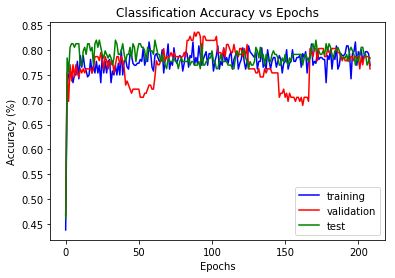

In [16]:
# plot training curve for classification accuracy vs number of epochs
plt.plot(train_accuracies, 'b-', label='training')
plt.plot(valid_accuracies, 'r-', label='validation')
plt.plot(test_accuracies, 'g-', label='test')
plt.title('Classification Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

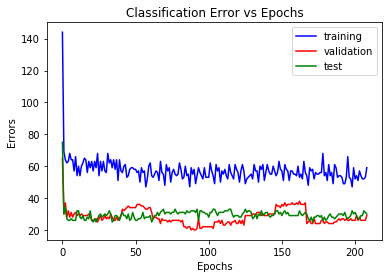

In [17]:
# plot training curve for classification errors vs number of epochs
plt.plot(train_errors, 'b-', label='training')
plt.plot(valid_errors, 'r-', label='validation')
plt.plot(test_errors, 'g-', label='test')
plt.title('Classification Error vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Errors')
plt.legend()

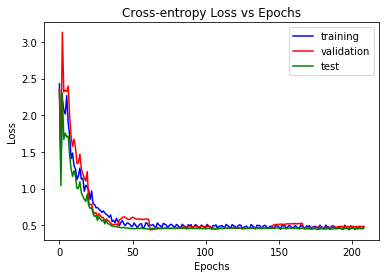

In [18]:
# plot training and validation for cross-entropy loss vs number of epochs
plt.plot(train_xentropy_losses, 'b-', label='training')
plt.plot(valid_xentropy_losses, 'r-', label='validation')
plt.plot(test_xentropy_losses, 'g-', label='test')
plt.title('Cross-entropy Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()